During the Fall semester of 2017, [CSU, Chico](http://www.csuchico.edu/)'s [Dr. Ann Bykerk-Kauffman](http://www.csuchico.edu/%7eabykerk-kauffman/) gave one of three talks at the [Department of Geological and Environmental Sciences](http://www.csuchico.edu/geos/index.shtml) seminar titled [2017 Hurricane Talk](http://www.csuchico.edu/geos/stories/17.09.14_HurricaneTalk.shtml).  Part of Dr. Bykerk-Kauffman's presentation included data from the National Hurricane Center's (NHC) Data Archive: https://www.nhc.noaa.gov/data/#hurdat.  After her talk, Dr. David M. Hassenzahl, Dean of the [College of Natural Sciences](https://www.csuchico.edu/nsci/index.shtml), asked a great question, which I'll try to paraphrase:  Is the variation in the (empirical) storm season changing over time?  This blog post seeks to answer that question and then slightly expand on the idea.

The HURDAT2 data used here was slightly processed from the NHC data archive.  Specifically, storms from both the Pacific and Atlantic oceans were combined.

Throughout, we'll use [Python 3](https://www.python.org/) and various packages common to Python's datascience community, and [Stan](http://mc-stan.org/) the probabilistic programming language to fit the statistical models.  The source code and data are available on [GitHub](https://github.com/roualdes/stormevents/).

In [45]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import bplot as bp
import datetime
import pystan
import stan_utility
import requests
import scipy
%matplotlib inline

The slightly processed (for this analysis) data are also hosted on GitHub.

In [78]:
df = pd.read_csv('https://raw.githubusercontent.com/roualdes/stormevents/master/data.csv')

To properly work with dates in Python, we convert dates, in the format YYYMMDD, into formal datestime objects.

In [79]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.drop_duplicates('name', inplace=True) # don't double count storms
df = df.loc[df.date > pd.to_datetime('1915'), :].copy() # do we really only want > 1915
df['year'] = df.date.dt.year                                                         
#df['day'] = df.date.dt.day                                                           
df['cnum_dates'] = mdates.date2num([datetime.datetime(2018, d.month, d.day)                     
                         for _, d in df['date'].dropna().iteritems()]) 
df['num_dates'] = mdates.date2num([datetime.datetime(d.year, d.month, d.day)                     
                         for _, d in df['date'].iteritems()])


With dates properly set up, we can easily visualize the increasing number of storms we see each year.

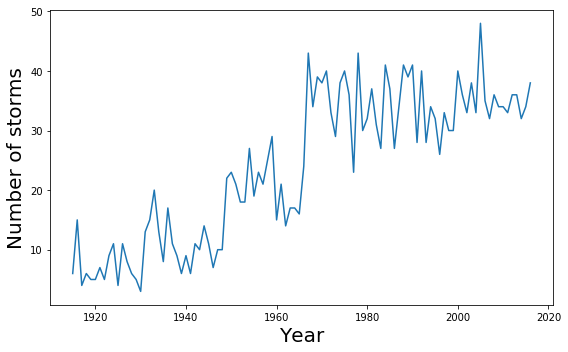

In [80]:
# This graph seems out of place
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], df['date'].dt.year.value_counts().sort_index())
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of storms', fontsize=20)
plt.tight_layout()

Or we can sum, within each month, the number storms that hit either the Pacific or Atlantic oceans.  During much of the 20th century, September was the most common month for a storm.

In [81]:
df['date'].dt.month.value_counts().sort_index()

1       5
2       1
3       1
4       5
5      71
6     220
7     379
8     582
9     679
10    369
11     96
12     14
Name: date, dtype: int64

Similar information is displayed with a density plot.  The density plot is nice because we can see how well the official storm season captures the highest density of storms.  Like above, the plot below is aggregated over all the years from 1915 forward.

In [82]:
storm_season = mdates.date2num([datetime.datetime(2018, 6, 1), 
                                datetime.datetime(2018, 10, 30)])
storm_season

array([736846., 736997.])

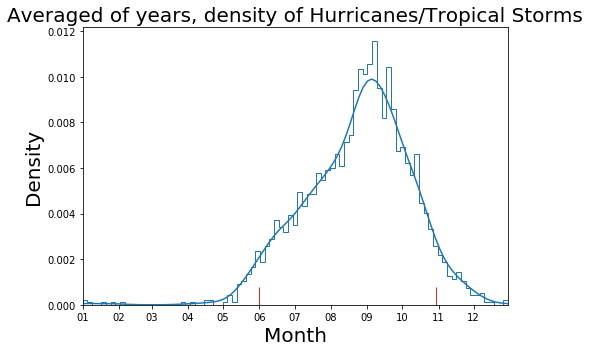

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.density(df['cnum_dates'])       
bp.histogram(df['cnum_dates'], bins=365//4)
bp.rug(storm_season, markersize=36, color='tab:red')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Averaged of years, density of Hurricanes/Tropical Storms', fontsize=20)
ax.set_xlim([df['cnum_dates'].min(), df['cnum_dates'].max()])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))                          
plt.tight_layout()

## Has the variation in the empirical storm season increased over time?

In an effort to answer Dean Hassenzahl's question, we will attempt to measure the variation in the empirical storm season.  To measure such variation, we will use the [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD) statistic.  The MAD statistic is an estimator of the population standard deviation σ, which is based on the median instead of the mean making it more robust to potential outliers.  

To measure the variation of the emprical storm season over time, first consider a year $Y$.  In year $Y$, there will be a handful of storms that occur at different times.  We define the median storm date by treating each day within the year as a number.  Technically, dates are given numbers relative to 0001-01-01 UTC plus 1; see [matplotlib dates](https://matplotlib.org/api/dates_api.html) for more details.  By this definition of a median, yearly median storm dates fall in August or September.

In [84]:
df['median'] = df.groupby('year')['num_dates'].transform(lambda x: x.median())
df['median_date'] = mdates.num2date(df['median'])
df.drop_duplicates('year', inplace=False)['median_date'].dt.month.value_counts().sort_index()

8    59
9    43
Name: median_date, dtype: int64

The median storm date strictly measures an average storm date within each year $Y$. Variation on the other hand measures average distance from the median storm date.  We will measure distance from the median storm date in days.  Since, some storms will occur before the median storm date and some storms after, we take the absolute value of the distance of each storm from the median storm date. Our MAD estimator is the median of the absolute values of these distances.  The last step scales our MAD estimator by $\frac{1}{\Phi^{-1}(0.75)} \approx 1.4826$, in a fairly standard assumption of normal data.  In the end, we have MAD estimates of the variation in the empirical storm season for each year in our data set.

In [85]:
df['mad'] = df.apply(lambda x: np.abs((x['num_dates'] - x['median'])), axis=1)
sdf = (df[['year', 'mad']].groupby('year', as_index=False)
            .aggregate(lambda x: 1.4826*np.median(x)))

A plot of the MAD estimators across time appears to show a possible slight positive slope.  A non-zero slope would indicate a change in the variation of the empirical storm season across time.  Hence, to answer Dean Hassenzahl's question, we seek to quantify statistically the slope of the following data.

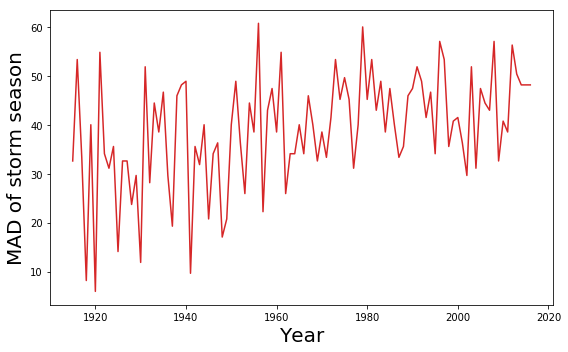

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'], color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('MAD of storm season', fontsize=20)
plt.tight_layout()

Fitting ordinary least squares to these data ignores all possible correlation in storm seasons across time.  Treating each year as independent is suspicious and can lead to over confident conclusions.

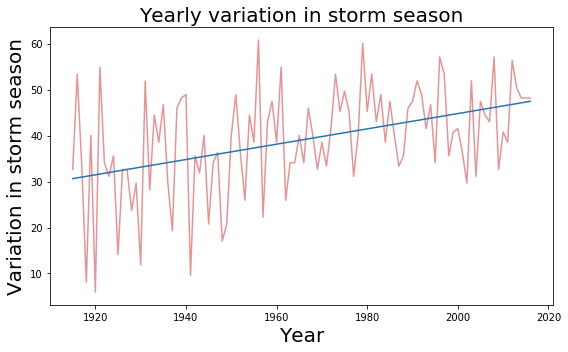

In [6]:
reg = sm.OLS(sdf['mad'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'], color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

The regression output below suggests that the variation in empirical storm season is increasing over time.  As stated before, I'm hesitant to admit that the storm season this year is not related to the storm season of next year in any way. 

In [32]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    mad   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     22.61
Date:                Thu, 07 Jun 2018   Prob (F-statistic):           6.69e-06
Time:                        12:04:31   Log-Likelihood:                -422.89
No. Observations:                 102   AIC:                             849.8
Df Residuals:                     100   BIC:                             855.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -427.3097    102.060     -4.187      0.0

To better model these data, such that we do not strictly rule out a correlation of the storm seasons across time, we will fit a Bayesian structural time series model using [Stan](http://mc-stan.org/).  The model is local linear trend model

$$ y_t = \mu_t + \epsilon_t \\
\mu_{t+1} = \mu_t + \nu_t + \gamma_t \\
\nu_{t+1} = \nu_t + \xi_t $$

where $\epsilon_t \sim \mathbb{N}(0, \sigma_{\epsilon}^2)$, $\gamma_t \sim \mathbb{N}(0, \sigma_{\gamma}^2)$, and $\xi_t \sim \mathbb{N}(0, \sigma_{\xi}^2)$ are independent.  The interested reader should consult [Time Series Analysis by State Space Methods](https://www.amazon.com/Time-Analysis-State-Space-Methods/dp/019964117X/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=BXZQ1XM11ZFFZDP4QVSP) for more details on the model.  

For our purposes, this model interests us because it will account for the correlation in storm seasons across time.  Further this model provides us with a parameter that describes something like a slope over time, namely $\nu_t$.  To see why $\nu_t$ is can be interpreted like a slope, consider the expected value of the change in the variable $y$ from time $t+1$ to $t$

$$ \mathbb{E}(y_{t+1} - y_t) = \mu_{t+1} - \mu_t = \mu_t + \nu_t - \mu_t = \nu_t$$

The above equation indicates that for every one unit increase in time, $y$ will change by $\nu$.  Note that I'm careful not to call it a slope, rather it's a parameter than can be interpreted like a slope.  This subtle differences is that in a local linear trend model, the slope-like term changes across time.

In Stan, we write this local linear trend model as follows.

In [132]:
#local_linear = requests.get('https://raw.githubusercontent.com/roualdes/stormevents/master/local_linear.stan').text
with open('local_linear.stan', 'r') as ll:
    local_linear = ll.read()
print(local_linear)

data {
  int <lower=1> T;
  vector[T] y;
  real y_scale;
  real u_scale;
  real v_scale;
}
transformed data {
  real sd_y = sd(y);
}
parameters {
  vector[T] u_err;
  real<lower=0> u_tau;
  vector[T] v_err;
  real<lower=0> v_tau;
  real<lower=0> y_err;
}
transformed parameters {
  vector[T] u;
  vector[T] v;

  u[1] = y[1] + u_tau * u_err[1];
  v[1] = v_tau * v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + u_tau * u_err[t-1];
    v[t] = v[t-1] + v_err[t-1];
  }
}
model {
  // priors
  v_err ~ normal(0, 1);
  v_tau ~ gamma(2, 1 / v_scale);
  u_err ~ normal(0, 1);
  u_tau ~ gamma(2, 1 / u_scale);
  y_err ~ gamma(2, 1 / (y_scale * sd_y));

  // likelihood
  y ~ normal(u, y_err);
}
generated quantities {
  vector[T] y_pred;
  for (t in 1:T)
    y_pred[t] = normal_rng(u[t], y_err);
}



In order to fit this model to the yearly variation in the storm season, we need to compile the above Stan program.

In [133]:
stmod = pystan.StanModel(model_code=local_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_911853c621e74c7c836b03146147df77 NOW.


We run the compiled model below and then overlay the estimates from the local linear trend model on top of the actual data we observed.

In [13]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['mad'].values.ravel(),                                                 
}
stfit = stmod.sampling(data=sdata, control={'max_treedepth': 20})                                                                                                                                    
posterior = stfit.extract()  

/Users/eroualdes/py3/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Stan models, like any other statistical model, are susceptible to problems. The checks below assure us that this model applied to these data offer nothing to be concerned about.

In [14]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


The plot below superimposes our fitted model over the MAD estimates of the annual variation in the storm season.  As expected, the local linear trend models is smoother than the original data.

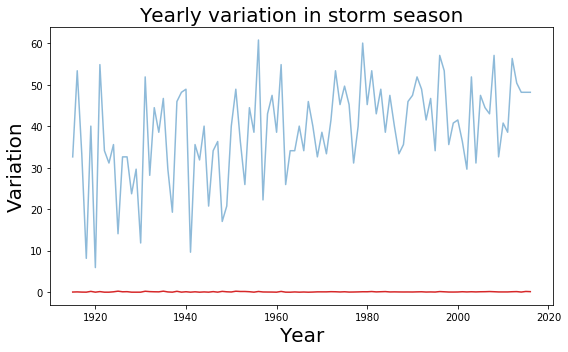

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['mad'], alpha=0.5, color='tab:red')                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0))                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

The figure below displays the estimates of slopes $\hat{\nu}_t$ across time as the solid blue line, and also $95\%$ posterior credible intervals in dashed blue lines.  The original data, centered at 0 to allow a comparison to the estimates $\hat{\nu}_t$, appears in faded red.

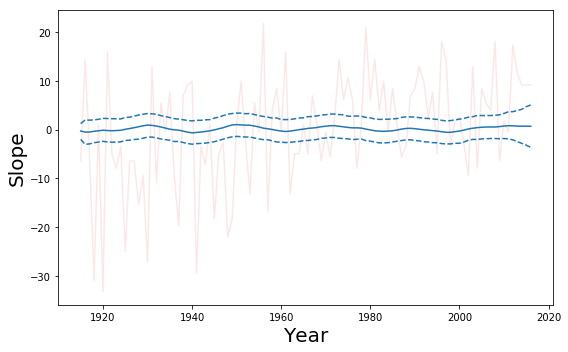

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'] - sdf['mad'].mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

Once we account for the correlation across time, it becomes clear that there is no slope-like estimate $\hat{\nu}_t$ that is large (in magnitude).  This suggests that depsite the fact that the number of storms is going up over time, the season is not significantly being stretched.  The two `False`s below confirm that for no value $t$ does either bound of the $95\%$ credible for $\hat{\nu}_t$ exclude $0$.

In [18]:
print(np.any(np.percentile(posterior['v'], [5], axis=0) > 0))
print(np.any(np.percentile(posterior['v'], [95], axis=0) < 0))

False
False


In short, we have some evidence that the variation in the empirical storm season is not increasing over time.  

Nonetheless, there are other ways to address the idea of Dr. Hassenzahl's question.  Below, we consider two alternative ways to measure a changing empirical storm season.

## Annual Proportion of Storms Outside Official Storm Season Increasing?

In [88]:
def outside_SS(df):
    y = df['year'].values[0]
    early = np.sum(df['date'] < datetime.datetime(y, 6, 1))
    late = np.sum(df['date'] > datetime.datetime(y, 10, 30))
    n = df['year'].shape[0]
    return (early + late) / n

sdf['prop'] = df.groupby('year', as_index=False).apply(outside_SS)

In [89]:
sdf.to_csv('yearly_data.csv')

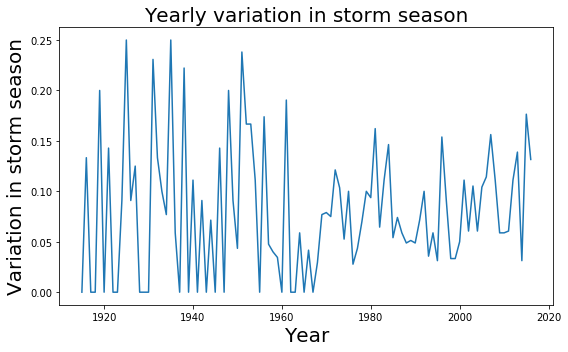

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

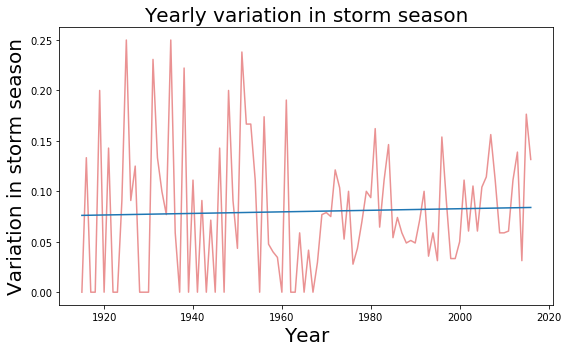

In [24]:
reg = sm.OLS(sdf['prop'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'], color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [58]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['prop'],      
    'sd_u': 1,
    'sd_v': 1,
}
stfit = stmod.sampling(data=sdata, control={'max_treedepth': 20, 'adapt_delta': 15})                                                                                                                                    
posterior = stfit.extract() 

/Users/eroualdes/py3/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [59]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
Chain 1: E-BFMI = 0.1328149667598416
  E-BFMI below 0.2 indicates you may need to reparameterize your model
1400.0 of 4000 iterations ended with a divergence (35.0%)
  Try running with larger adapt_delta to remove the divergences


0.0701060107246197
0.018355250751909667
0.022851424197434855


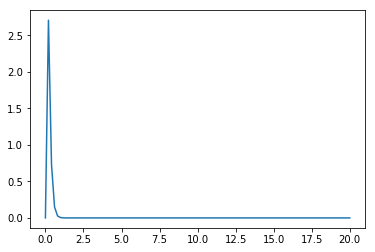

In [131]:
print(posterior['y_err'].mean(0))
print(posterior['u_tau'].mean(0))
print(posterior['v_tau'].mean(0))
x = np.linspace(0, 20, 101)
bp.curve(x, scipy.stats.gamma.pdf(x, 2, scale=1/10))

In [94]:
sdf['prop'].std(ddof=1)

0.06494529277198001

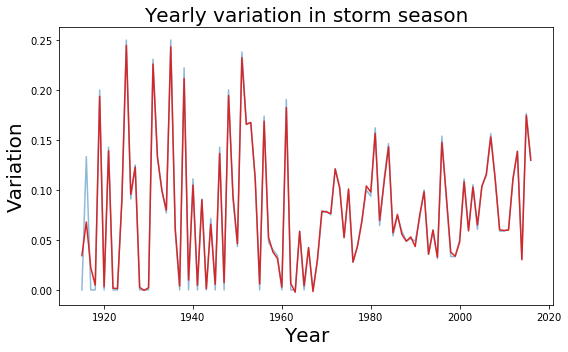

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['prop'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

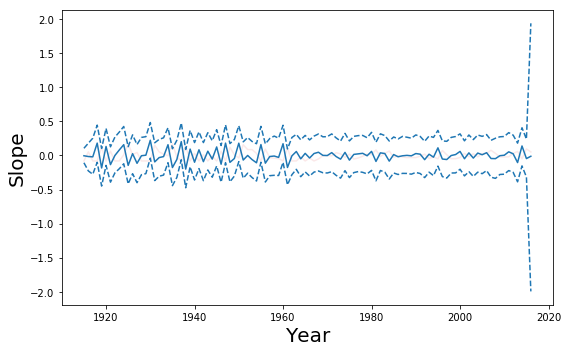

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'] - sdf['prop'].mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

In [34]:
print(np.any(np.percentile(posterior['v'], [5], axis=0) > 0))
print(np.any(np.percentile(posterior['v'], [95], axis=0) < 0))

True
True


## Stationary Distribution?

In [95]:
hist, bins = np.histogram(df['cnum_dates'], bins=df['cnum_dates'].nunique(), density=True)

In [96]:
cdf = np.cumsum(hist)
ecdf = cdf/cdf[-1]

In [97]:
ks = []
for year in np.nditer(df['date'].dt.year.unique()):
    h, _ = np.histogram(df['cnum_dates'][df['date'].dt.year == year], bins=df['cnum_dates'].nunique(), density=True)
    bcdf = np.cumsum(h)
    ks.append(np.max(np.abs(ecdf - bcdf/bcdf[-1])))
KS = np.array(ks)

In [98]:
KS

array([0.34709606, 0.2629232 , 0.46903386, 0.34310487, 0.49925681,
       0.38554913, 0.37200661, 0.62328654, 0.43453528, 0.24059755,
       0.74752271, 0.56452218, 0.53746903, 0.65455546, 0.56878613,
       0.66418938, 0.40138474, 0.35023397, 0.2576796 , 0.32004701,
       0.3659166 , 0.66663428, 0.29738758, 0.55569318, 0.41246903,
       0.28754932, 0.65964767, 0.42489303, 0.34838976, 0.35218827,
       0.25579911, 0.31213873, 0.37943848, 0.28546656, 0.14796186,
       0.299483  , 0.20355078, 0.33420497, 0.33819616, 0.56708567,
       0.24394802, 0.3809823 , 0.35645472, 0.32847234, 0.3607449 ,
       0.39256813, 0.27663088, 0.24401321, 0.29596347, 0.38939622,
       0.31002271, 0.28915497, 0.29833119, 0.41637927, 0.31682864,
       0.34662523, 0.47464905, 0.34091535, 0.33638486, 0.40129949,
       0.43255574, 0.29610515, 0.28957383, 0.3548576 , 0.40211946,
       0.51326383, 0.24876693, 0.40000266, 0.40662752, 0.46377716,
       0.52573259, 0.41893752, 0.26932044, 0.43938692, 0.52958

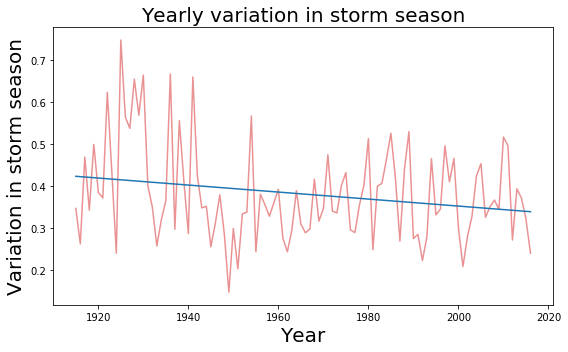

In [100]:
reg = sm.OLS(KS, sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], KS, color='tab:red', alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [14]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.830
Date:                Thu, 07 Jun 2018   Prob (F-statistic):             0.0303
Time:                        15:15:43   Log-Likelihood:                 78.938
No. Observations:                 102   AIC:                            -153.9
Df Residuals:                     100   BIC:                            -148.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0187      0.745      2.709      0.0

In [136]:
1 / .01 * KS.std(ddof=1)

11.482666123957411

In [143]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': KS,
    'y_scale': .01,
    'u_scale': .01,
    'v_scale': .01,
}
stfit = stmod.sampling(data=sdata, control={'max_treedepth': 20, 'adapt_delta': .95}) 
posterior = stfit.extract()

/Users/eroualdes/py3/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [144]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


In [146]:
stfit

Inference for Stan model: anon_model_911853c621e74c7c836b03146147df77.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
u_err[0]     -1.34    0.03   0.52  -2.59  -1.65  -1.26  -0.96  -0.55    403    1.0
u_err[1]      0.08    0.02   0.98  -1.88  -0.57   0.08   0.75   1.99   4000    1.0
u_err[2]   -5.4e-3    0.02   0.98  -1.96  -0.66-2.9e-3   0.66   1.91   4000    1.0
u_err[3]   -4.5e-3    0.02   0.99  -1.89  -0.68 5.1e-3   0.66   1.92   4000    1.0
u_err[4]     -0.02    0.02    1.0  -2.02  -0.67-3.7e-4   0.64   1.94   4000    1.0
u_err[5]   -5.7e-3    0.02    1.0  -1.94  -0.68-8.7e-3   0.67   2.02   4000    1.0
u_err[6]      0.05    0.02   0.98  -1.81  -0.62   0.06   0.71   1.95   4000    1.0
u_err[7]     -0.03    0.02   1.02  -2.05  -0.71  -0.03   0.66   1.99   4000    1.0
u_err[8]     -0.02    0.02   1.02  -2.02  -0.71  -0.02   0.67   

In [147]:
print(posterior['y_err'].mean(0))
print(posterior['u_tau'].mean(0))
print(posterior['v_tau'].mean(0))
#0.06431995210680218
#0.04796380469692231
#0.18404116313566338

0.0130395662015817
0.02730877403091919
0.016095579321693747


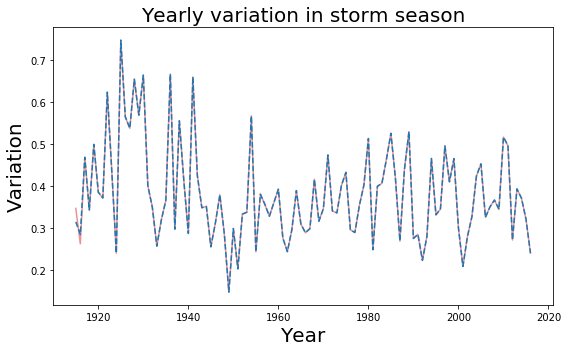

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], KS, alpha=0.5, color='tab:red')                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), linestyle='--')  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

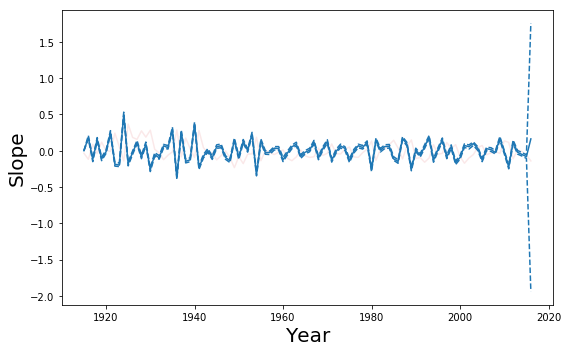

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], KS - KS.mean(), color='tab:red', alpha=0.1)
bp.curve(sdf['year'], np.percentile(posterior['v'],  [2.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], np.percentile(posterior['v'], [97.5], axis=0)[0], linestyle='--')
bp.curve(sdf['year'], posterior['v'].mean(axis=0))
plt.xlabel('Year', fontsize=20)
plt.ylabel('Slope', fontsize=20)
plt.tight_layout()

In [36]:
posterior['y_err'].mean()

0.05961377754954965